# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Hydroxylated-hif-1-Targets:" data-toc-modified-id="Hydroxylated-hif-1-Targets:-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Hydroxylated hif-1 Targets:</a></div><div class="lev1 toc-item"><a href="#Plotting-HIF-1-Hydroxyl-Downstream-Targets:" data-toc-modified-id="Plotting-HIF-1-Hydroxyl-Downstream-Targets:-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Plotting HIF-1 Hydroxyl Downstream Targets:</a></div>

In [1]:
# important stuff:
import os
import pandas as pd
import numpy as np

# TEA and morgan
import genpy
import gvars
import morgan as morgan
import seqplotter
import tissue_enrichment_analysis as tea

# Graphics
import matplotlib as mpl
import matplotlib.ticker as plticker
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as path_effects
from matplotlib import rc
# rc('text', usetex=True)
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

# Magic function to make matplotlib inline;
%matplotlib inline

# This enables SVG graphics inline. 
# There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

ft = 35 #title fontsize

mpl.rcParams['xtick.labelsize'] = 18 
mpl.rcParams['ytick.labelsize'] = 18 
mpl.rcParams['legend.fontsize'] = 14

In [3]:
tissue_df = tea.fetch_dictionary()
phenotype_df = pd.read_csv('../input/phenotype_ontology.csv')
go_df = pd.read_csv('../input/go_dictionary.csv')

In [4]:
genvar = gvars.genvars()

In [5]:
tf_df = pd.read_csv('../input/tf_list.csv')
hypoxia_gold = pd.read_csv('../input/hypoxia_gold_standard.csv',
                           sep=',')

In [6]:
# Specify the genotypes to refer to:
single_mutants = ['b', 'c', 'd', 'e', 'g']
# Specify which genotypes are double mutants 
# and of what single mutants:
double_mutants = {'a' : 'bd', 'f':'bc'}

# initialize the morgan.hunt object:
thomas = morgan.hunt('target_id', 'b', 'tpm', 'qval')

# input the genmap file:
thomas.add_genmap('../input/library_genotype_mapping.txt', comment='#')

# add the names of the single mutants
thomas.add_single_mutant(single_mutants)

# add the names of the double mutants
thomas.add_double_mutants(['a', 'f'], ['bd', 'bc'])

# set the q-value threshold for significance to its default value, 0.1
thomas.set_qval()

# Add the tpm files: 
kallisto_loc = '../input/kallisto_all/'
thomas.add_tpm(kallisto_loc, '/kallisto/abundance.tsv', '')

# Make all possible combinations of WT, X
combs = {}
for gene in thomas.genmap.genotype.unique():
    if gene != 'wt':
        combs[gene] = 'WT_'+gene+'/'

# # load all the beta values for each genotype:
# sleuth_loc = '../sleuth/'
# thomas.add_betas(sleuth_loc, 'betas.csv', combs)

# load all the beta values for each genotype:
sleuth_loc = '../sleuth_all_adjusted/kallisto/'
for file in os.listdir("../sleuth_all_adjusted/kallisto"):
    if file[:4] == 'beta':
        letter = file[-5:-4].lower()
        thomas.add_beta(sleuth_loc + file, letter)
        thomas.beta[letter].sort_values('target_id', inplace=True)
        thomas.beta[letter].reset_index(inplace=True)
thomas.filter_data(0, 0.1)

In [7]:
frames = []
for key, df in thomas.beta.items():
    df['code'] = key
    df['genotype'] = genvar.fancy_mapping[key]
    frames += [df]

tidy_data = pd.concat(frames)

# Hydroxylated hif-1 Targets:

In [8]:
df1 = thomas.beta['f'].copy()
df2 = thomas.beta['c']
df3 = thomas.beta['e']
df4 = thomas.beta['b']
df5 = thomas.beta['a'] 
df6 = thomas.beta['d']

df1['b_c'] = df2.b
df1['b_e'] = df3.b
df1['b_b'] = df4.b
df1['b_a'] = df5.b
df1['b_d'] = df6.b

df1['se_b_c'] = df2.se_b
df1['se_b_e'] = df3.se_b
df1['se_b_b'] = df4.se_b
df1['se_b_a'] = df5.se_b
df1['se_b_d'] = df6.se_b

df1['q_c'] = df2.qval
df1['q_e'] = df3.qval
df1['q_b'] = df4.qval
df1['q_a'] = df5.qval
df1['q_d'] = df6.qval

In [9]:
n = 1

# use least strict conditions:
lowestrhy = (df1.b_e*df1.b_d < 0)  # egl anti vhl

lowestsigrhy = ((df1.q_e < 10**-n) &  # egl sig
                (df1.q_d < 10**-n))   # vhl sig
               

lowestegl = (df1.b_b*df1.b_d < 0)  # egl anti vhl


lowestsigegl = ((df1.q_b < 10**-n) &  # egl sig
                (df1.q_d < 10**-n))   # vhl sig

In [10]:
sorter = {'a': 5,
          'f': 6,
          'b': 2,
          'c': 4,
          'd': 3,
          'e': 1,
          'g': 7
         }

df1.sort_values('q_c', ascending=True)

hifoh = df1[
        (lowestegl & lowestsigegl) |
        (lowestrhy & lowestsigrhy)].target_id.values

x_sort = {}
for i, xi in enumerate(hifoh):
    x_sort[xi] = i + 1

print('{0} candidates found for HIF-1-OH regulation'.format(len(hifoh)))
df1[(lowestegl & lowestsigegl) |
    (lowestrhy & lowestsigrhy)].to_csv('../output/hifoh_candidates.csv', index=False)

31 candidates found for HIF-1-OH regulation


# Plotting HIF-1 Hydroxyl Downstream Targets:

In [11]:
tidy = tidy_data[(tidy_data.target_id.isin(hifoh)) & (tidy_data.code != 'g')].copy()
tidy['order'] = tidy.target_id.map(x_sort)
tidy.sort_values('order', inplace=True)
tidy.reset_index(inplace=True)  
# tidy = tidy[['target_id', 'ens_gene', 'ext_gene','b', 'se_b', 'qval', 'genotype', 'order', 'code']]

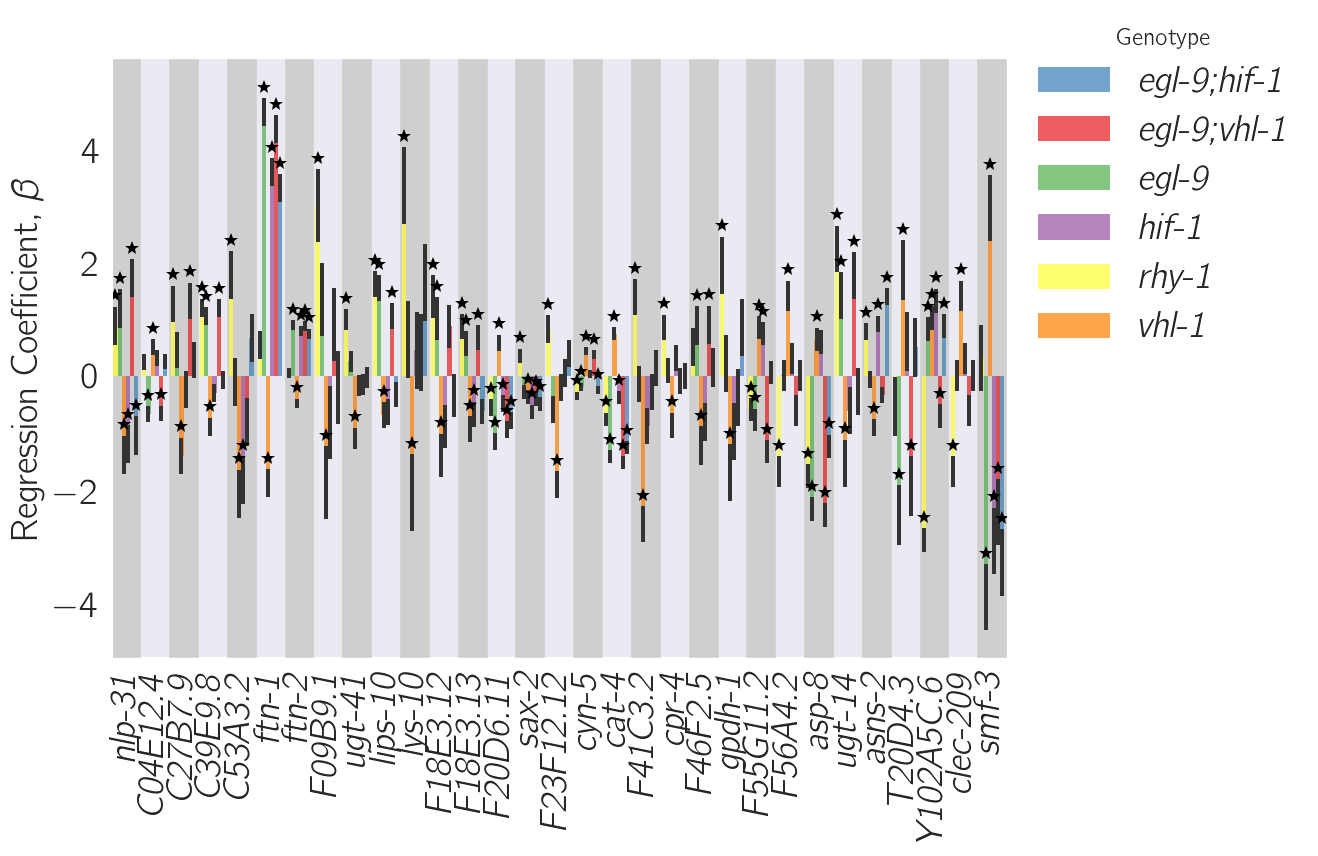

In [12]:
genpy.qPCR_plot(tidy, genvar.plot_order, genvar.plot_color,
                clustering='genotype', plotting_group='target_id', rotation=90)

In [13]:
df1[df1.target_id.isin(hifoh)].to_csv('../output/hifoh_regulation_candidates.csv', index=False)

In [14]:
new_order = {r'\emph{egl-9}': 0,
             r'\emph{vhl-1}': 1,
            }

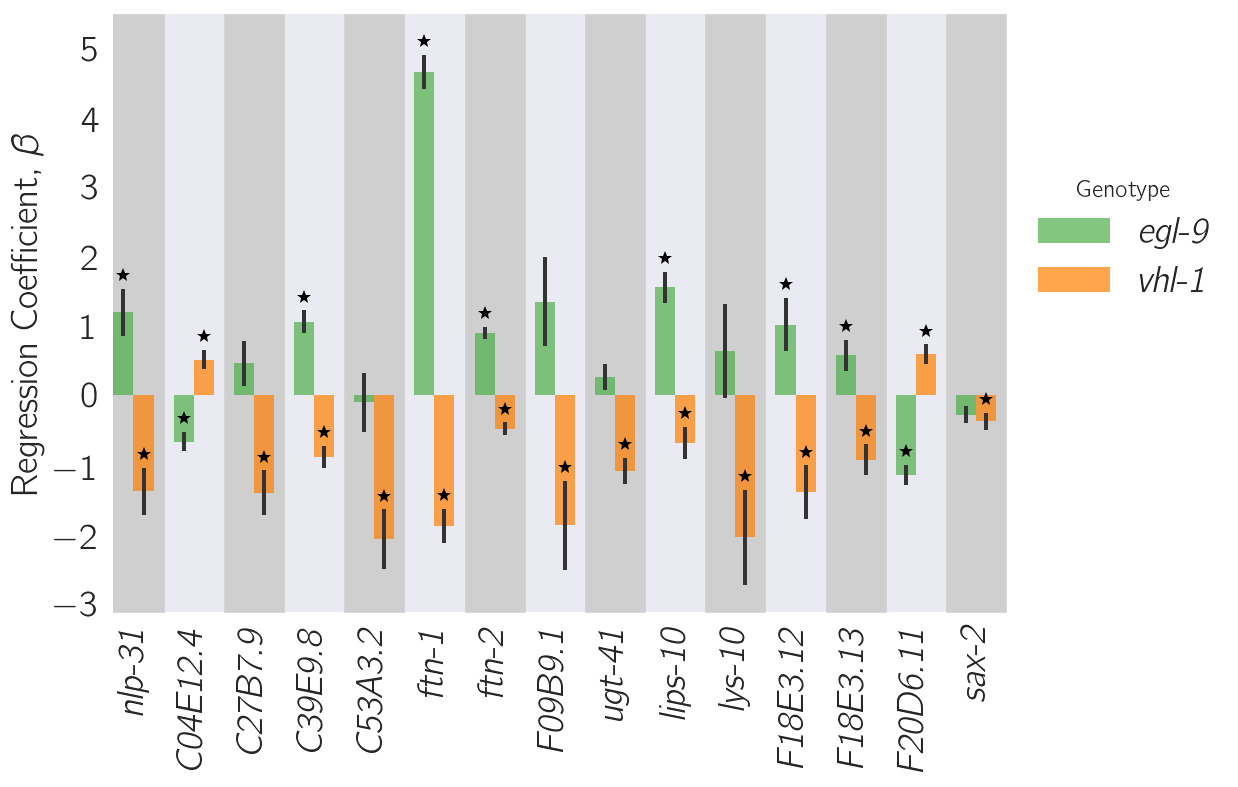

In [15]:
genpy.qPCR_plot(tidy[(tidy.target_id.isin(hifoh[0:15])) & (tidy.code.isin(['b', 'd']))],
                new_order, genvar.plot_color, clustering='genotype',
                plotting_group='target_id',
                title='Non-classical epistasis in the \emph{hif-1} pathway',
                save='../output/egl_opposes_vhl.svg', rotation=90)

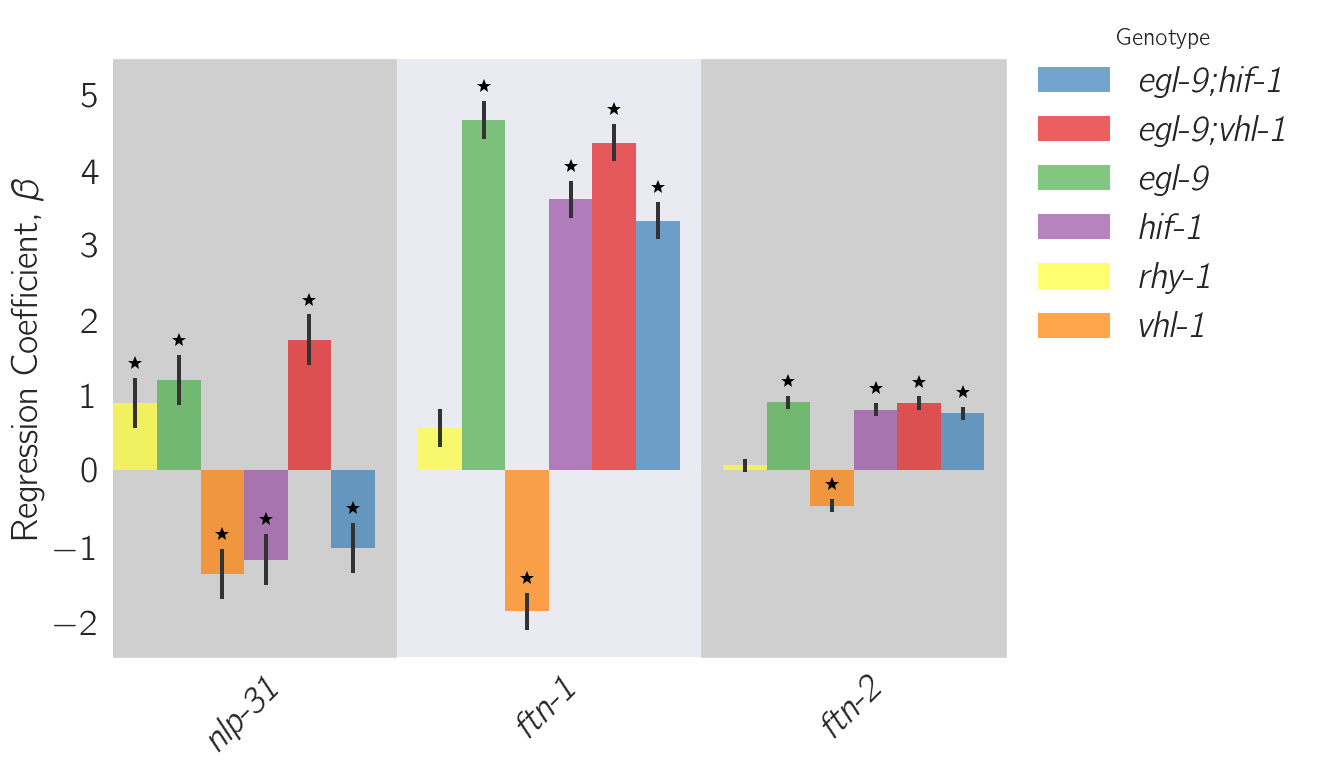

In [17]:
to_focus_on = ['nlp-31', 'ftn-1', 'ftn-2']

gene_order = {'nlp-31': 1, 'ftn-1': 2, 'ftn-2': 3}

temp = tidy[(tidy.ext_gene.isin(to_focus_on))].copy()
del temp['order']
temp['order'] = temp.ext_gene.map(gene_order)

genpy.qPCR_plot(temp,
                genvar.plot_order, genvar.plot_color, clustering='genotype',
                plotting_group='ext_gene')
plt.savefig('../output/hif1oh_qPCR.svg', bbox_inches='tight')